**Estudo de caso - Dataset Mnist fashion**

Este estudo de caso busca explorar o conjunto de dados Mnist fashion e aplicar uma rede neural para predizer a classe ao qual a imagem pertence.

In [104]:
# Import das bibliotecas
# Dataset
from keras.datasets import mnist

# Processamento
from google.colab.patches import cv2_imshow
import cv2 
import numpy as np
import zipfile
import os

# Construção da rede
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Google colab

from google.colab import drive

# Métricas de avaliação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Salvar o modelo
from keras.models import save_model

In [168]:
def mostrar_imagem(imagem):
  ''' Mostra a imagem redimensionada para 200 x 200 pixels
      Parâmetros:
        imagem: Imagem a ser exibida
  ''' 
  cv2_imshow(cv2.resize(imagem, dsize=(200, 200), interpolation=cv2.INTER_CUBIC))
  
def histograma_imagem(imagem):
  ''' Plota o histograma com as distribuições dos pixels de uma imagem
      Parâmetros:
        imagem: imagem que o histograma será mostrado
  '''
  plt.hist(imagem)
  
def converter_matriz_vetor(matriz):
  ''' Converte uma matriz em um vetor nparray
      Parâmetros:
        matriz -> matriz a ser convertida no vetor
  '''
  return np.asarray([x.ravel() for x in matriz])
  
def plotar_graficos(graficos, titulos):
  fig, axes = plt.subplots(1, len(graficos), figsize = (10, 10), linewidth=3)

  for i in range(0, len(axes)):
    axes[i].plot(graficos[i])
    if len(titulos) > i:
      axes[i].set_title(titulos[i])

def verificar_predicao(indice_classificacao, X, y, classificacao):
  ''' Verifica a predição do modelo mostrando a classe real e a classe predita, bem como o plot da imagem do dataset de teste
      Parâmetros:
        indice_classificacao -> indice do item a ser verificado
        X -> dados de teste
        y -> label dos dados de teste
        classificacao -> dados da classificação realizada pelo modelo
  '''
  classe_real = y[indice_classificacao]
  classe_predita = classificacao[indice_classificacao]
  predicao = 'acertou' if classe_real == classe_predita else 'errou'
  print(f'Classe real: {classe_real}\nClasse predita: {classe_predita}\nModelo { predicao }')
  mostrar_imagem(X[indice_classificacao].reshape(28,28))
  
def salvar_modelo_pesos(modelo, nome_arq_modelo, nome_arq_peso):
  ''' Salva o modelo em um arquivo .json e os pesos em um arquivo .hdf5
      Parâmetros:
        modelo -> modelo a ser salvo
        nome_arq_modelo -> nome do arquivo que o modelo será salvo
        nome_arq_peso -> nome do arquivo que os pesos serão salvos
  ''' 
  # Converte o modelo para json
  modelo_json = modelo.to_json()
  # Salva o arquivo do modelo em json
  with open(nome_arq_modelo + '.json', 'w') as json_file:
    json_file.write(modelo_json)
  # Salva os pesos
  # O padrão é salvar em um arquivo .hdf5
  rede_salva = save_model(modelo, nome_arq_peso + '.hdf5')

def carregar_modelo_salvo(arquivo_json_modelo, arquivo_pesos):
  ''' Carrega e retorna o modelo salvo no disco
      Parâmetros:
        arquivo_sjon_modelo ->  Arquivo json contendo o modelo
        arquivo_pesos -> Arquivo com os pesos do modelo
  '''
  with open(arquivo_json_modelo) as json_file:
    modelo_json = json_file.read()
  rede_carregada = tf.keras.models.model_from_json(modelo_json)
  rede_carregada.load_weights(arquivo_pesos)
  return rede_carregada

def normalizar_classificacao(classificacoes):
  ''' Normalizar a classificação e retornar a lista com as classes provaveis para cada classificação
      Parâmetros:
        classificacoes -> lista com as classificacoes
  '''
  # Verifica a predição e pega o maior valor como sendo considerada a saída correta
  # Converte para inteiro para ser possível verificar na matriz de confusão
  classificacao_normalizada = []
  for classificacao in classificacoes:
    classificacao_normalizada.append(int(np.argmax(classificacao)))
  return classificacao_normalizada

def encontrar_predicoes_incorretas(y_teste, classificacoes_normalizadas):
  ''' Encontra e imprime as predições incorretas do modelo.
      Parâmetros:
        y_teste -> labels corretas
        classificacoes_normalizadas -> labels preditas
  '''
  s = ''
  for i in range(0, len(classificacoes_normalizadas)):
    if y_teste[i] != classificacoes_normalizadas[i]:
      s += str(i) + ', '
  print(s[:-2])

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
from keras.datasets import fashion_mnist
(X_treino, y_treino), (X_teste, y_teste) = fashion_mnist.load_data()

In [108]:
imagem_dataset_original = X_treino[0]
altura = imagem_dataset_original.shape[0]
largura = imagem_dataset_original.shape[1] 
qtd_pixels = largura * altura
print(f'Sumário do dataset:\nQtd de imagens de treino {X_treino.shape[0]} - labels de treino {y_treino.shape[0]}\nQtd Imagens de teste: {X_teste.shape[0]} - labels de teste {y_teste.shape[0]}')
print(f'Shape imagem de exemplo do dataset: {imagem_dataset_original.shape}\nAltura: {altura}\nLargura: {largura}\nQtd de pixels: {qtd_pixels}')

Sumário do dataset:
Qtd de imagens de treino 60000 - labels de treino 60000
Qtd Imagens de teste: 10000 - labels de teste 10000
Shape imagem de exemplo do dataset: (28, 28)
Altura: 28
Largura: 28
Qtd de pixels: 784


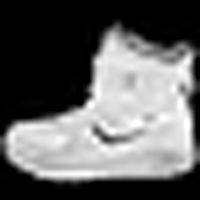

In [109]:
mostrar_imagem(imagem_dataset_original)

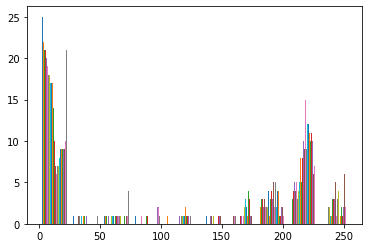

In [110]:
histograma_imagem(imagem_dataset_original)

In [111]:
imagem_teste = []

for x in range(0, imagem_dataset_original.shape[0]):
  linha = []
  for y in range(0, imagem_dataset_original.shape[1]):
   linha.append(int(imagem_dataset_original[x][y] < 50 or imagem_dataset_original[x][y] > 200) * 255)
  imagem_teste.append(linha)

In [112]:
imagem_teste = np.asarray(imagem_teste)
print(imagem_teste.shape)

(28, 28)


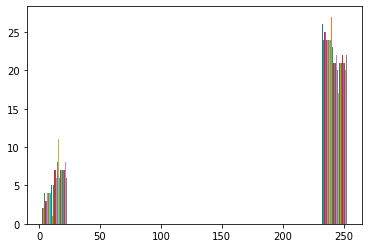

In [113]:
histograma_imagem(imagem_teste)

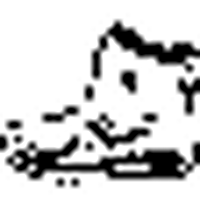

In [114]:
mostrar_imagem(imagem_teste.astype('uint8'))

In [124]:
# Normalizando a imagem colocando-a no intervalo de zero a um
X_treino = X_treino / 255.0
X_teste = X_teste / 255.0

# Convertendo para vetor a matriz de imagens
X_treino = converter_matriz_vetor(X_treino)
X_teste = converter_matriz_vetor(X_teste)

In [125]:
numero_pixels = 28 * 28
numero_unidades = (28 * 28 + 2) / 2

In [126]:
print(f'Número de pixels: {numero_pixels}\nNúmero de unidades: {numero_unidades}')

Número de pixels: 784
Número de unidades: 393.0


In [130]:
print(y_treino.shape)

(60000,)


In [139]:
# Construção da rede neural
rede = tf.keras.Sequential()

rede.add(tf.keras.layers.Dense(input_shape = (numero_pixels,), units = numero_unidades, activation = 'relu'))
rede.add(tf.keras.layers.Dense(units = numero_unidades, activation = 'relu'))
rede.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))

In [141]:
rede.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
progresso = rede.fit(X_treino, y_treino, epochs = 30)

Epoch 1/30
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4681 - accuracy: 0.8299
Epoch 2/30
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3538 - accuracy: 0.8702
Epoch 3/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3160 - accuracy: 0.8818
Epoch 4/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2959 - accuracy: 0.8898
Epoch 5/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2763 - accuracy: 0.8963
Epoch 6/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2647 - accuracy: 0.9002
Epoch 7/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2535 - accuracy: 0.9046
Epoch 8/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2411 - accuracy: 0.9086
Epoch 9/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2312 - accuracy: 0.9117
Epoch 10/30
1875/1875 [==============================] - 10s 5ms/step - l

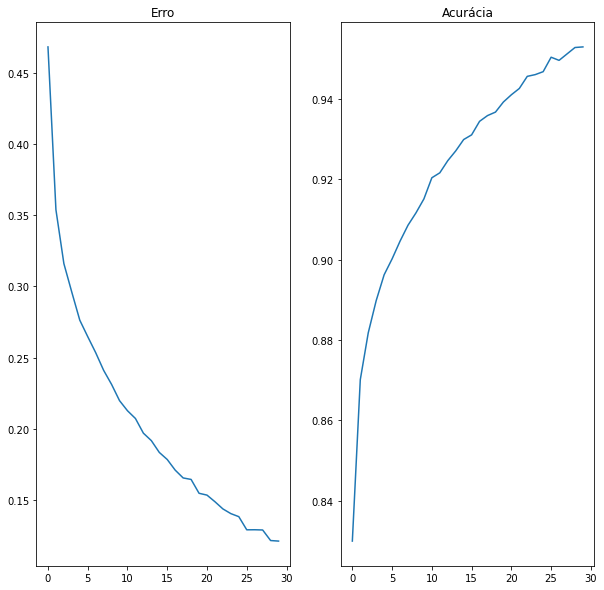

In [142]:
plotar_graficos([progresso.history['loss'],
                 progresso.history['accuracy']],
                 ['Erro', 'Acurácia'])

In [143]:
test_loss, test_acc = rede.evaluate(X_teste, y_teste, verbose=2)

313/313 - 1s - loss: 0.4902 - accuracy: 0.8915 - 1s/epoch - 4ms/step


In [144]:
classificacoes = rede.predict(X_teste)

In [153]:
classificacoes_normalizadas = normalizar_classificacao(classificacoes)

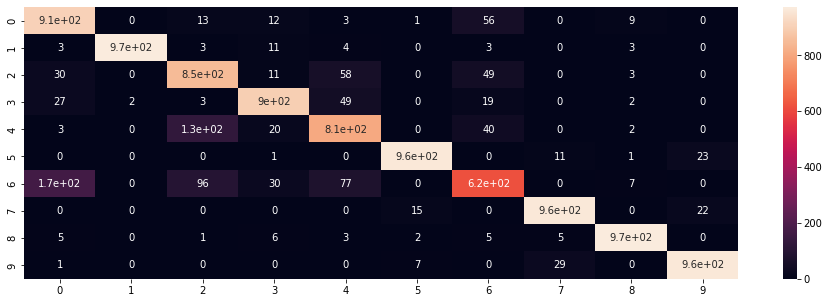

In [154]:
cm = confusion_matrix(y_teste, classificacoes_normalizadas)
plt.figure(figsize = (16,5))
sns.heatmap(cm, annot = True)

Classe real: 2
Classe predita: 2
Modelo acertou


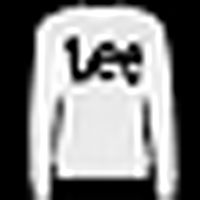

In [157]:
verificar_predicao(1, X_teste * 255, y_teste, classificacoes_normalizadas)

Classe real: 8
Classe predita: 8
Modelo acertou


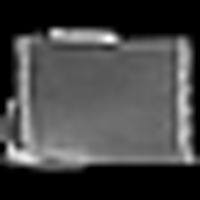

In [158]:
verificar_predicao(105, X_teste * 255, y_teste, classificacoes_normalizadas)

Classe real: 2
Classe predita: 2
Modelo acertou


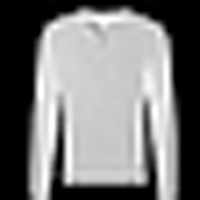

In [159]:
verificar_predicao(258, X_teste * 255, y_teste, classificacoes_normalizadas)

Classe real: 6
Classe predita: 0
Modelo errou


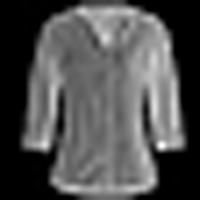

In [166]:
verificar_predicao(4, X_teste * 255, y_teste, classificacoes_normalizadas)

Classe real: 7
Classe predita: 5
Modelo errou


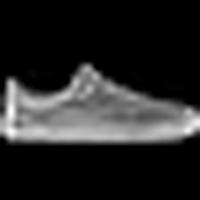

In [167]:
verificar_predicao(12, X_teste * 255, y_teste, classificacoes_normalizadas)

**Testes com diferentes números de epócas**

Objetivo: 

- Verificar a acurácia da rede ao realizar o treino com diferentes quantidades de epócas.

Número de epócas = 1 - Acurácia = 88 %

Número de epócas = 5 - Acurácia = 89 %

Número de epócas = 10 - Acurácia = 89 %

Número de epócas = 20 - Acurácia = 89 %

Número de epócas = 50 - Acurácia = 89 %

Número de epócas = 150 - Acurácia = 89 %

In [170]:
def treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, nEpocas):
  ''' Treinar e testar a rede com diferentes números de epocas e imprimir a acurácia
      Parâmetros:
        X_treino -> Dados de treino
        y_treino -> labels de treino
        X_teste -> Dados de teste
        y_teste -> labels de teste
        nEpocas -> número de épocas do treino
  '''
  rede.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  progresso = rede.fit(X_treino, y_treino, epochs = nEpocas)

  test_loss, test_acc = rede.evaluate(X_teste, y_teste, verbose=2)
  print('----------------')
  print(f'Acurácia: {test_acc}')

In [171]:
treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, 5)


Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.1218 - accuracy: 0.9530
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1187 - accuracy: 0.9547
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1141 - accuracy: 0.9554
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1105 - accuracy: 0.9582
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1074 - accuracy: 0.9582
313/313 - 1s - loss: 0.5739 - accuracy: 0.8941 - 819ms/epoch - 3ms/step
----------------
Acurácia: 0.89410001039505


In [172]:
treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, 10)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1108 - accuracy: 0.9586
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1099 - accuracy: 0.9583
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1049 - accuracy: 0.9609
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1006 - accuracy: 0.9611
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0998 - accuracy: 0.9623
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0979 - accuracy: 0.9631
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0961 - accuracy: 0.9642
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0936 - accuracy: 0.9648
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0930 - accuracy: 0.9644
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

In [174]:
treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, 50)

Epoch 1/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0721 - accuracy: 0.9740
Epoch 2/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0709 - accuracy: 0.9743
Epoch 3/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0706 - accuracy: 0.9752
Epoch 4/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0680 - accuracy: 0.9757
Epoch 5/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0729 - accuracy: 0.9742
Epoch 6/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0654 - accuracy: 0.9763
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0620 - accuracy: 0.9771
Epoch 8/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0652 - accuracy: 0.9765
Epoch 9/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0662 - accuracy: 0.9766
Epoch 10/50
1875/1875 [==============================] - 11s 6ms/step - l

In [175]:
treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, 150)

Epoch 1/150
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0510 - accuracy: 0.9829
Epoch 2/150
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0515 - accuracy: 0.9835
Epoch 3/150
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0435 - accuracy: 0.9856
Epoch 4/150
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0460 - accuracy: 0.9845
Epoch 5/150
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 6/150
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0496 - accuracy: 0.9844
Epoch 7/150
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0500 - accuracy: 0.9844
Epoch 8/150
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0464 - accuracy: 0.9848
Epoch 9/150
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0514 - accuracy: 0.9846
Epoch 10/150
1875/1875 [==============================] - 10s 5m

In [177]:
treinar_testar_rede(X_treino, y_treino, X_teste, y_teste, 1)

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0354 - accuracy: 0.9917
313/313 - 1s - loss: 3.0604 - accuracy: 0.8860 - 797ms/epoch - 3ms/step
----------------
Acurácia: 0.8859999775886536


**Conclusão**

O modelo conseguiu predizer bem os resultados obtendo 89% de acurácia para diiferentes números de epócas. O modelo se saiu bem, contudo estagnou em 89% de acurácia, sendo, portanto necessário a exploração de mais técnicas para melhorar a acurácia da detecção.